In [1]:
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../input/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [5]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

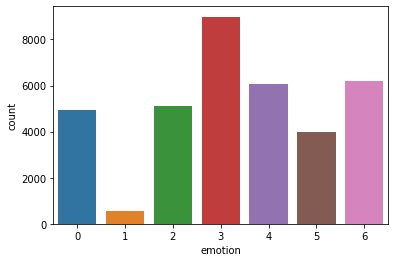

In [6]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

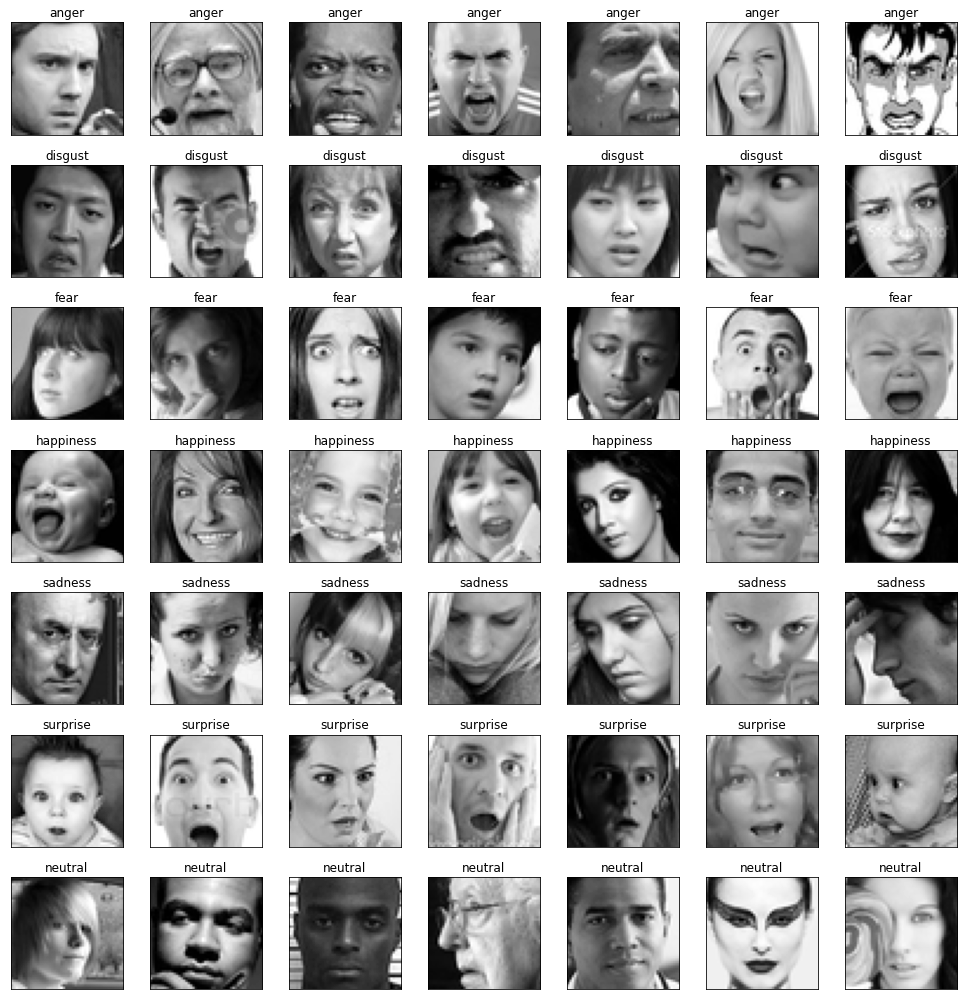

In [8]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [9]:
INTERESTED_LABELS = [3, 4, 6]

In [10]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

`Now I will make the data compatible for neural networks.`

In [11]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [12]:
img_array.shape

(21264, 48, 48, 1)

In [13]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [15]:
facial_landmarks = joblib.load("../input/fer2013-facial-landmarks/facial_landmarks.pkl")
facial_landmarks.shape

(21264, 68, 2)

In [16]:
print("extracting HOG features, this may take some minutes...")

hog_feats = []
for img in img_array:
    img = img.astype("uint8")
    img_ = cv2.resize(img, (64,128))
    # img_ = cv2.equalizeHist(img_)

    hog = cv2.HOGDescriptor()
    hog_descr = hog.compute(img_)
    hog_feats.append(hog_descr)


hog_feats = np.array(hog_feats)
print(hog_feats.shape)

extracting HOG features, this may take some minutes...
(21264, 3780, 1)


`Splitting the data into training and validation set.`

In [17]:
Xtrain_img, Xvalid_img, Xtrain_fl, Xvalid_fl, Xtrain_hog, Xvalid_hog, y_train, y_valid = \
train_test_split(img_array, facial_landmarks, hog_feats, img_labels,
                shuffle=True, stratify=img_labels, test_size=0.1,
                random_state=42)

print(Xtrain_img.shape, Xtrain_fl.shape, Xtrain_hog.shape, y_train.shape)
print(Xvalid_img.shape, Xvalid_fl.shape, Xvalid_hog.shape, y_valid.shape)

(19137, 48, 48, 1) (19137, 68, 2) (19137, 3780, 1) (19137, 3)
(2127, 48, 48, 1) (2127, 68, 2) (2127, 3780, 1) (2127, 3)


In [18]:
img_width = Xtrain_img.shape[1]
img_height = Xtrain_img.shape[2]
img_depth = Xtrain_img.shape[3]
num_classes = y_train.shape[1]

In [19]:
# Normalizing image arrays
Xtrain_img = Xtrain_img / 255.
Xvalid_img = Xvalid_img / 255.

In [20]:
def dcnn_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_DCNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten_dcnn')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_dcnn'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4')(batchnorm_7)
    
    return model_in, model_out

In [21]:
def facial_landmarks_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_Facial_Landmarks")
    flatten = Flatten(name="flatten_fl")(model_in)
    dense1 = Dense(64, activation="relu", name="dense1_fl")(flatten)
    model_out = Dropout(0.4, name='dropout1_fl')(dense1)
    
    return model_in, model_out

In [22]:
def facial_HOG_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_Facial_HOG")
    flatten = Flatten(name="flatten_hog")(model_in)
    dense1 = Dense(256, activation="relu", name="dense1_hog")(flatten)
    model_out = Dropout(0.4, name='dropout1_hog')(dense1)
        
    return model_in, model_out

In [23]:
def merge_models(models_in: list, models_out: list, num_classes: int, show_summary=False):
    
    concated = Concatenate()(models_out)
    dropout_1 = Dropout(0.4, name='dropout1_model')(concated)

    dense1 = Dense(256, activation="relu", name="dense1")(dropout_1)
    dropout_2 = Dropout(0.4, name='dropout2_model')(dense1)
    out = Dense(num_classes, activation="softmax", name="out_layer")(dropout_2)

    model = Model(inputs=models_in, outputs=out, name="FER_Model")

    if show_summary:
        model.summary()
    
    return model

In [24]:
dcnn_in, dcnn_out = dcnn_pipeline(input_shape=(48,48,1))
fl_in, fl_out = facial_landmarks_pipeline(input_shape=(68,2))
hog_in, hog_out = facial_HOG_pipeline(input_shape=(3780,1))

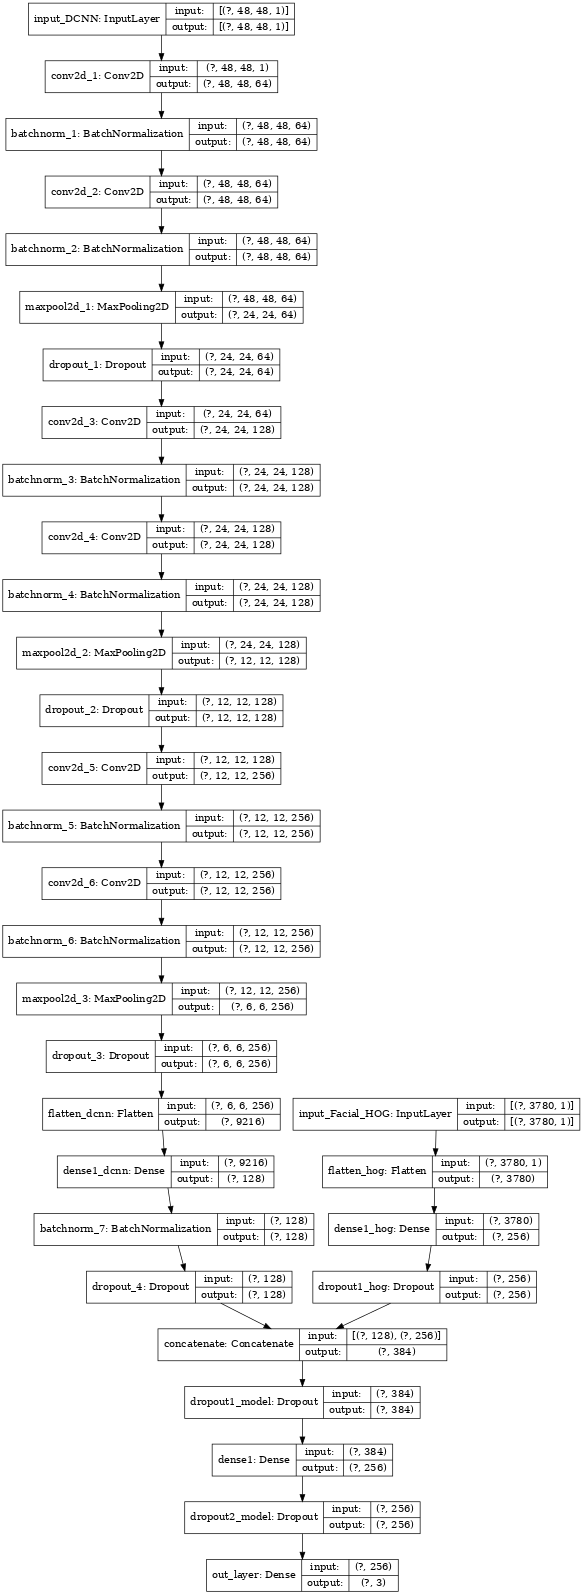

In [25]:
model = merge_models(
    models_in=[dcnn_in, hog_in],
    models_out=[dcnn_out, hog_out],
    num_classes=3
)
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model_1.png')

In [26]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00025,
    factor=0.25,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

The below data generator is taken from [this](https://github.com/keras-team/keras/issues/3386) keras issue thread.

In [27]:
def data_generator(Xtrain_img, Xtain_hog, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        batches = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False)
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], Xtain_hog[idx[ idx0:idx1 ]]], batch[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break

In [28]:
batch_size = 32
epochs = 45
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit(
    data_generator(Xtrain_img, Xtrain_hog, y_train, batch_size=batch_size,),
    validation_data=([Xvalid_img, Xvalid_hog], y_valid),
    steps_per_epoch=len(Xtrain_img) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train for 598.03125 steps, validate on 2127 samples
Epoch 1/45
599/598 [==============================] - 19s 32ms/step - loss: 1.1421 - accuracy: 0.4600 - val_loss: 0.8858 - val_accuracy: 0.5877
Epoch 2/45
599/598 [==============================] - 13s 21ms/step - loss: 0.9231 - accuracy: 0.5488 - val_loss: 0.8446 - val_accuracy: 0.6079
Epoch 3/45
599/598 [==============================] - 13s 21ms/step - loss: 0.8928 - accuracy: 0.5704 - val_loss: 0.8340 - val_accuracy: 0.6201
Epoch 4/45
599/598 [==============================] - 14s 24ms/step - loss: 0.8771 - accuracy: 0.5795 - val_loss: 0.8120 - val_accuracy: 0.6314
Epoch 5/45
599/598 [==============================] - 13s 21ms/step - loss: 0.8564 - accuracy: 0.5938 - val_loss: 0.8212 - val_accuracy: 0.6084
Epoch 6/45
599/598 [==============================] - 13s 21ms/step - loss: 0.8474 - accuracy: 0.5964 - val_loss: 0.8305 - val_accuracy: 0.6027
Epoch 7/45
599/598 [==============================] - 12s 21ms/step - loss: 0.8179 -

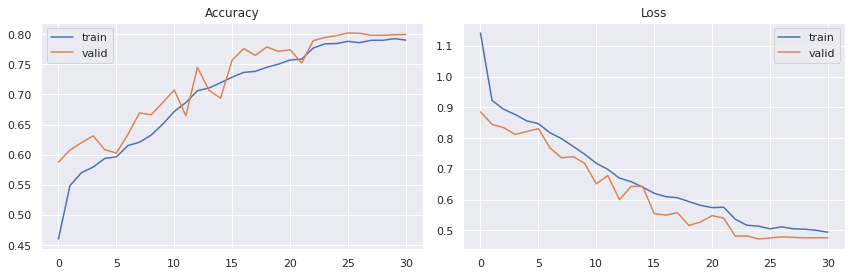

In [32]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_multipipe_model.png')
pyplot.show()

In [33]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

total wrong validation predictions: 421


              precision    recall  f1-score   support

           0       0.93      0.90      0.91       899
           1       0.75      0.70      0.72       608
           2       0.68      0.76      0.72       620

    accuracy                           0.80      2127
   macro avg       0.79      0.79      0.79      2127
weighted avg       0.81      0.80      0.80      2127



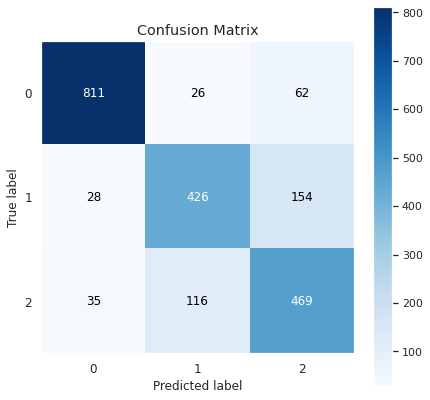

In [34]:
yhat_valid = model.predict([Xvalid_img, Xvalid_hog, Xvalid_fl])
yhat_valid = np.argmax(yhat_valid, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))